# 4. 键值对操作
键值对 RDD 是 Spark 中许多操作所需要的常见数据类型。键值对 RDD 通常用来进行聚合计算。我们一般要先通过一些初始 ETL（抽取、转 化、装载）操作来将数据转化为键值对形式。

为了运行本章的例子，首先创建一个PySpark环境sc：

In [1]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster('local').setAppName('Demo')
sc = SparkContext(conf=conf)
sc

<SparkContext master=local appName=Demo>

## 4.1 动机
Spark 为包含键值对类型的 RDD 提供了一些专有的操作。这些 RDD 被称为 pair RDD。Pair RDD 是很多程序的构成要素，因为它们提供了并行操作各个键或跨节点重新进行数据分组的操作接口。例如，pair RDD 提供 reduceByKey() 方法，可以分别归约每个键对应的数据，还有 join() 方法，可以把两个 RDD 中键相同的元素组合到一起，合并为一个 RDD。我们通常从一个 RDD 中提取某些字段（例如代表事件时间、用户 ID 或者其他标识符的字段），并使用这些字段作为 pair RDD 操作中的键。

## 4.2 创建Pair RDD
在 Spark 中有很多种创建 pair RDD 的方式，很多存储键值对的数据格式会在读取时直接返回由其键值对数据组成的 pair RDD。此外，当需要把一个普通的 RDD 转为 pair RDD 时，可以调用 map() 函数来实现，传递的函数需要返回键值对。

**例 4-1：在 Python 中使用第一个单词作为键创建出一个 pair RDD**

In [2]:
lines = sc.textFile("kvs.txt")
pairs = lines.map(lambda x: (x.split(" ")[0], x))
pairs.collect()

[('name', 'name blademaster'), ('age', 'age 1000'), ('nation', 'nation china')]

## 4.3 Pair RDD的转化操作
Pair RDD 可以使用所有标准 RDD 上的可用的转化操作，所有有关传递函数的规则也都同样适用于 pair RDD。由于 pair RDD 中包含二元组，所以需要传递的函数应当操作二元组而不是独立的元素。下面表格总结了对 pair RDD 的一些转化操作：

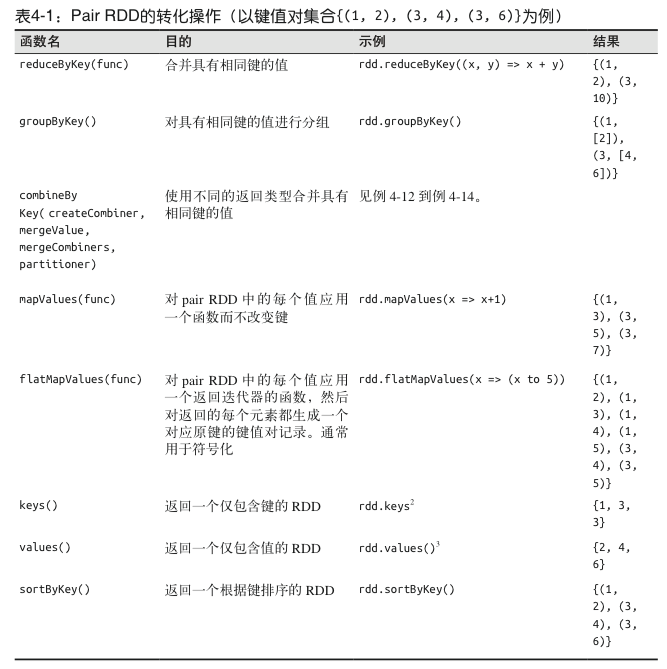

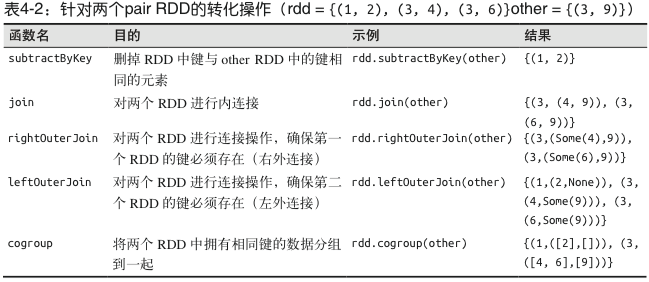


Pair RDD也还是RDD， 因此同样支持RDD所支持的函数。

**例4-4：用Python对第二个元素进行筛选**

In [3]:
result = pairs.filter(lambda keyValue: len(keyValue[1]) < 10)
result.collect()

[('age', 'age 1000')]

### 4.3.1 聚合操作
当数据集以键值对形式组织的时候，聚合具有相同键的元素进行一些统计是很常见的操作。

`reduceByKey()`与reduce()相当类似；它们都接收一个函数，并使用该函数对值进行合并。reduceByKey()会为数据集中的每个键进行并行的归约操作，每个归约操作会将键相同的值合并起来。因为数据集中可能有大量的键，所以reduceByKey()没有被实现为向用户程序返回一个值的行动操作。*实际上，它会返回一个由各键和对应键归约出来的结果值组成的新的RDD*。

`foldByKey()`则与fold()相当类似；它们都使用一个与RDD和合并函数中的数据类型相同的零值作为初始值。与fold()一样，foldByKey()操作所使用的合并函数对零值与另一个元素进行合并，结果仍为该元素。

**例 4-7：在Python中使用reduceByKey()和mapValues()计算每个键对应的平均值**

In [4]:
kvs = sc.parallelize([("panda", 0), ("pink", 3), ("pirate", 3), ("panda", 1), ("pink", 4)])
result = kvs.mapValues(lambda x: (x, 1)).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
result.collect()

[('panda', (1, 2)), ('pink', (7, 2)), ('pirate', (3, 1))]

代码运行原理如下：
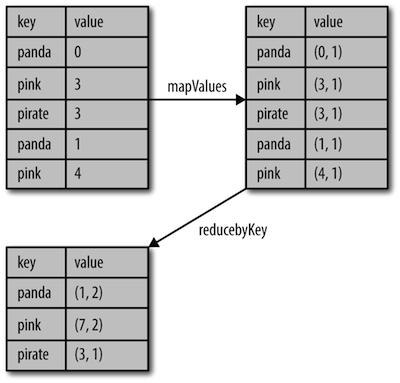

> 熟悉MapReduce中的合并器（combiner）概念的读者可能已经注意到，调用reduceByKey()和foldByKey()会在为每个键计算全局的总结果之前先自动在每台机器上进行本地合并。用户不需要指定合并器。更泛化的combineByKey()接口可以让你自定义合并的行为。

**例4-9：用Python实现单词计数**

In [5]:
rdd = sc.textFile("kvs.txt")
words = rdd.flatMap(lambda x: x.split(" "))
result = words.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)
result.collect()

[('china', 1),
 ('nation', 1),
 ('blademaster', 1),
 ('age', 1),
 ('1000', 1),
 ('name', 1)]

combineByKey()是最常用的基于键进行聚合的函数。大多数基于键聚合的函数都是用它实现的。 和aggregate()一样，combineByKey()可以让用户返回与输入数据的类型不同的返回值。

combineByKey()会遍历分区中的所有元素，因此每个元素的键要么还没有遇到过，要么就和之前的某个元素的键相同。如果这是一个新的元素，combineByKey()会调用createCombiner()函数来创建那个键对应的累加器的初始值。需要注意的是，这一过程会在每个分区中第一次出现各个键时发生，而不是在整个RDD中第一次出现一个键时发生。如果这是一个在处理当前分区之前已经遇到的键，它会调用mergeValue()方法将该键的累加器对应的当前值与这个新的值进行合并。

由于每个分区都是独立处理的，因此对于同一个键可以有多个累加器。如果有两个或者更多的分区都有对应同一个键的累加器，就需要使用用户提供的mergeCombiners()方法将各个分区的结果进行合并。

combineByKey()有多个参数分别对应聚合操作的各个阶段，因而非常适合用来解释聚合操作各个阶段的功能划分。为了更好地演示combineByKey()是如何工作的，下面来看看如何计算各键对应的平均值。

**例4-12：在Python中使用combineByKey()求每个键对应的平均值**

In [14]:
kvs = sc.parallelize([("panda", 0), ("pink", 3), ("pirate", 3), ("panda", 1), ("pink", 4)])
sumCount =  kvs.combineByKey((lambda x: (x, 1)),
                             (lambda x, y: (x[0] + y, x[1] + 1)),
                             (lambda x, y: (x[0] + y[0], x[1] + y[1]))) 
sumCount.collect()
# sumCount.map(lambda key, xy: (key, xy[0]/xy[1])).collectAsMap()

[('panda', (1, 2)), ('pink', (7, 2)), ('pirate', (3, 1))]

In [23]:
# sumCount.map(lambda key, xy: (key, xy[0]/xy[1])).collectAsMap()
# 原文的写法有个错误，在python 3已经不能使用‘Tuple parameter unpacking’
# 参考：https://stackoverflow.com/questions/26543349/python-3-map-lambda-method-with-2-inputs
result = sumCount.map(lambda args: (args[0], args[1][0]/args[1][1]))
result.collect()

[('panda', 0.5), ('pink', 3.5), ('pirate', 3.0)]

#### 并行度调优
每个RDD都有固定数目的分区，分区数决定了在RDD上执行操作时的并行度。

在执行聚合或分组操作时，可以要求Spark使用给定的分区数。Spark始终尝试根据集群的大小推断出一个有意义的默认值，但是有时候你可能要对并行度进行调优来获取更好的性能表现。

**例4-15：在Python中自定义reduceByKey()的并行度**

In [27]:
data = [("a", 3), ("b", 4), ("a", 1)] 
sc.parallelize(data).reduceByKey(lambda x, y: x + y) 
sc.parallelize(data).reduceByKey(lambda x, y: x + y, 10)

PythonRDD[115] at RDD at PythonRDD.scala:48

有时，我们希望在除分组操作和聚合操作之外的操作中也能改变RDD的分区。对于这样的情况，Spark提供了repartition()函数，它会把数据通过网络进行混洗，并创建出新的分区集合。切记，对数据进行重新分区是代价相对比较大的操作。Spark中也有一个优化版的repartition()，叫作coalesce()。你可以使用Java或Scala中的rdd.partitions.size以及Python中的rdd.getNumPartitions查看RDD的分区数，并确保调用coalesce()时将RDD合并到比现在的分区数更少的分区中。

### 4.3.2 数据分组
如果数据已经以预期的方式提取了键，groupByKey()就会使用RDD中的键来对数据进行分组。 对于一个由类型K的键和类型V的值组成的RDD， 所得到的结果RDD类型会是[K, Iterable[V]]。

groupByKey()可以用于未成对的数据上，也可以根据除键相同以外的条件进行分组。它可以接收一个函数，对源RDD中的每个元素使用该函数，将返回结果作为键再进行分组。

除了对单个RDD的数据进行分组，还可以使用一个叫作cogroup()的函数对多个共享同一个键的RDD进行分组。对两个键的类型均为K而值的类型分别为V和W的RDD进行cogroup()时，得到的结果RDD类型为[(K, (Iterable[V], Iterable[W]))]。如果其中的一个RDD对于另一个RDD中存在的某个键没有对应的记录，那么对应的迭代器则为空。cogroup()提供了为多个RDD进行数据分组的方法。

cogroup() 是下一节中要讲的连接操作的构成要素。

### 4.3.3 连接
连接数据可能是pair RDD最常用的操作。连接方式多种多样：右外连接、左外连接、交叉连接以及内连接。下面的例子显示几种连接方式：

In [29]:
ds1 = [("a", 1), ("b", 2), ("c", 3)] 
ds2 = [("a", 3), ("b", 4), ("d", 5)]
rdd1 = sc.parallelize(ds1)
rdd2 = sc.parallelize(ds2)

# 内连接
result = rdd1.join(rdd2)
result.collect()

[('b', (2, 4)), ('a', (1, 3))]

In [30]:
# 左外连接
result = rdd1.leftOuterJoin(rdd2)
result.collect()

[('c', (3, None)), ('b', (2, 4)), ('a', (1, 3))]

In [31]:
# 右外连接
result = rdd1.rightOuterJoin(rdd2)
result.collect()

[('b', (2, 4)), ('d', (None, 5)), ('a', (1, 3))]

### 4.3.4 数据排序
如果键有已定义的顺序，就可以对这种键值对RDD进行排序。当把数据排好序后，后续对数据进行collect()或save()等操作都会得到有序的数据。

sortByKey()函数接收一个ascending的参数，表示我们是否想要让结果按升序排序（默认值为true）。也可以提供自定义的比较函数。

**例4-19：在Python中以字符串顺序对整数进行自定义排序**

In [33]:
rdd = sc.parallelize([(1, 'a'), (3, 'c'), (2, 'b')] )
result = rdd.sortByKey(ascending=True, numPartitions=None, keyfunc = lambda x: str(x))
result.collect()

[(1, 'a'), (2, 'b'), (3, 'c')]

## 4.4 Pair RDD的行动操作
所有基础RDD支持的传统行动操作也都在pair RDD上可用。 Pair RDD提供了一些额外的行动操作，可以让我们充分利用数据的键值对特性：
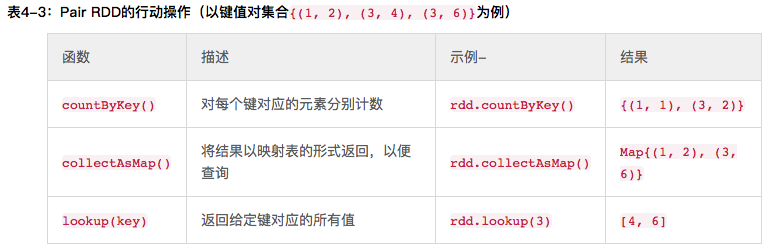

## 4.5 数据分区
在分布式程序中，通信的代价是很大的，因此控制数据分布以获得最少的网络传输可以极大地提升整体性能。和单节点的程序需要为记录集合选择合适的数据结构一样，Spark程序可以通过控制RDD分区方式来减少通信开销。分区并不是对所有应用都有好处的——比如，如果给定RDD只需要被扫描一次，我们完全没有必要对其预先进行分区处理。只有当数据集多次在诸如连接这种基于键的操作中使用时，分区才会有帮助。

Spark中所有的pair RDD都可以进行分区。系统会根据一个针对键的函数对元素进行分组。尽管Spark没有给出显示控制每个键具体落在哪一个工作节点上的方法（部分原因是Spark即使在某些节点失败时依然可以工作），但Spark可以确保同一组的键出现在同一个节点上。

假设我们分析这样一个应用，它在内存中保存着一张很大的用户信息表，即一个由(UserID, UserInfo)对组成的RDD，其中UserInfo包含一个该用户所订阅的主题的列表。该应用会周期性地将这张表与一个小文件进行组合，这个小文件中存着过去五分钟内发生的事件，即一个由(UserID, LinkInfo)对组成的表，存放着过去五分钟内某网站各用户的访问情况。例如，我们可能需要对用户访问其未订阅主题的页面的情况进行统计。 我们可以使用join()操作来实现这个组合操作，其中需要把UserInfo和LinkInfo的有序对根据UserID进行分组：

```scala
// 初始化代码；从HDFS上的一个Hadoop SequenceFile中读取用户信息
// userData中的元素会根据它们被读取时的来源，即HDFS块所在的节点来分布
// Spark此时无法获知某个特定的UserID对应的记录位于哪个节点上
val sc = new SparkContext(...)
val userData = sc.sequenceFile[UserID, UserInfo]("hdfs://...").persist()

// 周期性调用函数来处理过去五分钟产生的事件日志
// 假设这是一个包含(UserID, LinkInfo)对的SequenceFile
def processNewLogs(logFileName: String) {
  val events = sc.sequenceFile[UserID, LinkInfo](logFileName)
  // RDD of (UserID, (UserInfo, LinkInfo)) pairs
  val joined = userData.join(events)
  val offTopicVisits = joined.filter {
    case (userId, (userInfo, linkInfo)) => // Expand the tuple into its components
      !userInfo.topics.contains(linkInfo.topic)
  }.count()
  println("Number of visits to non-subscribed topics: " + offTopicVisits)
}
```

这段代码可以正确运行但不够高效，因为每次调用processNewLogs()时都会用到join()操作，而我们对数据集是如何分区的却一无所知。默认情况下，连接操作会将两个数据集中的所有键的哈希值都求出来，将该哈希值相同的记录通过网络传到同一台机器上，然后在那台机器上对所有键相同的记录进行连接操作（见下图）。由于userData表比访问日志表events要大得多，所以要浪费时间做很多额外工作：在每次调用时都对userData表进行哈希值计算和跨节点数据混洗，虽然这些数据从来都不会变化。

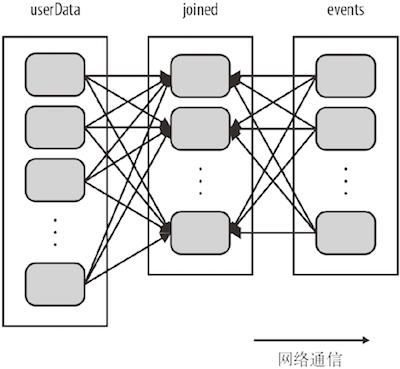

要解决这个问题，我们可以在程序开始时对userData表使用partitionBy()转化操作，将这张表转为哈希分区：

```scala
val sc = new SparkContext(...)
val userData = sc.sequenceFile[UserID, UserInfo]("hdfs://...")
                 .partitionBy(new HashPartitioner(100))
                 .persist()
```

processNewLogs()方法可以保持不变：eventsRDD 是本地变量，只在该方法中使用了一次，所以为events指定分区方式没有什么用处。由于userData根据键的哈希值来分区的，这样在调用join()时，Spark只会对events进行数据混洗操作，将events中特定UserID的记录发送到userData的对应分区所在的那台机器。这样，需要通过网络传输的数据就大大减少了。

注意，partitionBy()是一个转化操作，因此它的返回值总是一个新的RDD，但它不会改变原来的RDD。RDD一旦创建就无法修改。因此应该对partitionBy()的结果进行持久化，并保存为userData，而不是原来的sequenceFile()的输出。此外，传给partitionBy()的100表示分区数目，它会控制之后对这个RDD进行进一步操作时有多少任务会并行执行。总的来说，这个值至少应该和集群中的总核心数一样。

> 如果没有将partitionBy()转化操作的结果持久化，那么后面每次用到这个RDD时都会重复地对数据进行分区操作。

事实上，除join()外还有很多操作也会利用到已有的分区信息。比如，sortByKey()和 groupByKey()会分别生成范围分区的RDD和哈希分区的RDD。而另一方面，诸如map()这样的操作会导致新的RDD失去父RDD的分区信息，因为这样的操作理论上可能会修改每条记录的键。

### 4.5.1 获取RDD的分区方式
在Scala和Java中，你可以使用RDD的partitioner属性来获取RDD的分区方式。

Python API没有提供查询分区方式的方法，但是Spark内部仍然会利用已有的分区信息。

在Spark shell中使用partitioner属性不仅是检验各种Spark操作如何影响分区方式的一种好办法，还可以用来在你的程序中检查想要使用的操作是否会生成正确的结果：

```shell
import org.apache.spark
scala> val pairs = sc.parallelize(List((1, 1), (2, 2), (3, 3)))
pairs: spark.RDD[(Int, Int)] = ParallelCollectionRDD[0] at parallelize at
<console>:12

scala> pairs.partitioner
res0: Option[spark.Partitioner] = None

scala> val partitioned = pairs.partitionBy(new spark.HashPartitioner(2))
partitioned: spark.RDD[(Int, Int)] = ShuffledRDD[1] at partitionBy at <console>:14

scala> partitioned.partitioner
res1: Option[spark.Partitioner] = Some(spark.HashPartitioner@5147788d)
```

### 4.5.2 从分区中获益的操作
Spark的许多操作都引入了将数据根据键跨节点进行混洗的过程。能够从数据分区中获益的操作有cogroup()、groupWith()、join()、leftOuterJoin()、rightOuterJoin()、groupByKey()、reduceByKey()、combineByKey()以及lookup()。

对于像reduceByKey()这样只作用于单个RDD的操作，运行在未分区的RDD上的时候会导致每个键的所有对应值都在每台机器上进行本地计算，只需要把本地最终归约出的结果值从各工作节点传回主节点，所以原本的网络开销就不算大。

对于诸如cogroup()和join()这样的二元操作，预先进行数据分区会导致其中至少一个RDD不发生数据混洗。如果两个RDD使用同样的分区方式，并且它们还缓存在同样的机器上（比如一个RDD是通过mapValues()从另一个RDD中创建出来的，这两个RDD就会拥有相同的键和分区方式），或者其中一个RDD还没有被计算出来，那么跨节点的数据混洗就不会发生了。

### 4.5.3 影响分区方式的操作
Spark内部知道各操作会如何影响分区方式，并将会对数据进行分区的操作的结果RDD自动设置为对应的分区器。例如，如果你调用join()来连接两个RDD；由于键相同的元素会被哈希到同一台机器上，Spark知道输出结果也是哈希分区的，这样对连接的结果进行诸如reduceByKey()这样的操作时就会明显变快。

不过，转化操作的结果并不一定会按已知的分区方式分区，这时输出的RDD可能就会没有设置分区器。例如，当你对一个哈希分区的键值对RDD调用map()时，由于传给map()的函数理论上可以改变元素的键，因此结果就不会有固定的分区方式。Spark不会分析你的函数来判断键是否会被保留下来。不过，Spark提供了另外两个操作mapValues()和flatMapValues()作为替代方法，它们可以保证每个二元组的键保持不变。

**这里列出了所有会为生成的结果RDD设好分区方式的操作**：cogroup()、groupWith()、join()、leftOuterJoin()、rightOuterJoin()、groupByKey()、reduceByKey()、combineByKey()、partitionBy()、sort()、mapValues()、flatMapValues()，以及 filter()（对于后三个RDD，前提是父RDD有分区）。其他所有的操作生成的结果都不会存在特定的分区方式。

最后，对于二元操作，输出数据的分区方式取决于父RDD的分区方式。默认情况下，结果会采用哈希分区，分区的数量和操作的并行度一样。不过，如果其中的一个父RDD 经设置过分区方式，那么结果就会采用那种分区方式；如果两个父RDD都设置过分区方式，结果RDD会采用第一个父RDD的分区方式。

### 4.5.5 自定义分区方式
HashPartitioner与RangePartitioner已经能够满足大多数用例，但Spark允许你自定义Partitioner对象来控制RDD的分区方式。

要实现自定义的分区器，需要继承org.apache.spark.Partitioner类并实现下面三个方法：
1. numPartitions: Int：返回创建出来的分区数
2. getPartition(key: Any): Int：返回给定键的分区编号（0到numPartitions-1）
3. equals()：Java 判断相等性的标准方法。这个方法的实现非常重要，Spark需要用这个方法来检查你的分区器对象是否和其他分区器实例相同，这样Spark才可以判断两个RDD的分区方式是否相同

**有一个问题需要注意，当你的算法依赖于Java的hashCode()方法时，这个方法有可能会返回负数。你需要十分谨慎，确保getPartition()永远返回一个非负数。**

**例4-27：Python自定义分区方式**
```python
import urlparse

def hash_domain(url):
  return hash(urlparse.urlparse(url).netloc)

rdd.partitionBy(20, hash_domain)　# 创建20个分区
```